_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
# Loading potential tools needed
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Data Inspection

In [2]:
train.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [3]:
train.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,51916,51293,51692,51904,51916,51863,51906,51916,51915,42261,51718
unique,17049,16350,329,3,13954,39,1,2257,51,42164,13410
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2017-03-23T00:00:00,Canvass,45. FOOD HANDLER REQUIREMENTS MET - Comments: ...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,654,802,34264,37731,741,51659,51906,50,24170,3,741


In [4]:
test.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,1.730600e+04,1.730400e+04,17298.000000,17245.000000,17245.000000,17306.000000
mean,1.323403e+06,1.562543e+06,60628.920338,41.879518,-87.676646,0.258581
std,6.240521e+05,8.947393e+05,23.462366,0.080895,0.059617,0.437867
min,4.426100e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,6.709562e+05,1.145506e+06,60614.000000,41.830619,-87.708016,0.000000
50%,1.418794e+06,1.964748e+06,60625.000000,41.890300,-87.666898,0.000000
75%,1.946488e+06,2.208688e+06,60643.000000,41.938989,-87.634501,1.000000
max,2.279564e+06,3.759896e+06,60827.000000,42.021064,-87.525872,1.000000


In [5]:
test.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,17306,17084,17219,17299,17306,17288,17304,17306,17306,14026,17245
unique,10131,9756,205,3,9296,19,1,2207,34,14016,9086
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2016-10-14T00:00:00,Canvass,45. FOOD HANDLER REQUIREMENTS MET - Comments: ...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,222,266,11375,12513,237,17214,17304,28,8012,3,237


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51916 entries, 0 to 51915
Data columns (total 17 columns):
Inspection ID      51916 non-null int64
DBA Name           51916 non-null object
AKA Name           51293 non-null object
License #          51911 non-null float64
Facility Type      51692 non-null object
Risk               51904 non-null object
Address            51916 non-null object
City               51863 non-null object
State              51906 non-null object
Zip                51890 non-null float64
Inspection Date    51916 non-null object
Inspection Type    51915 non-null object
Violations         42261 non-null object
Latitude           51718 non-null float64
Longitude          51718 non-null float64
Location           51718 non-null object
Fail               51916 non-null int64
dtypes: float64(4), int64(2), object(11)
memory usage: 6.7+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17306 entries, 0 to 17305
Data columns (total 17 columns):
Inspection ID      17306 non-null int64
DBA Name           17306 non-null object
AKA Name           17084 non-null object
License #          17304 non-null float64
Facility Type      17219 non-null object
Risk               17299 non-null object
Address            17306 non-null object
City               17288 non-null object
State              17304 non-null object
Zip                17298 non-null float64
Inspection Date    17306 non-null object
Inspection Type    17306 non-null object
Violations         14026 non-null object
Latitude           17245 non-null float64
Longitude          17245 non-null float64
Location           17245 non-null object
Fail               17306 non-null int64
dtypes: float64(4), int64(2), object(11)
memory usage: 2.2+ MB


### Preprocessing Results

In [8]:
X_test = test.drop(columns='Fail')
y_test = test['Fail']
X_train = train.drop(columns='Fail')
y_train = train['Fail']

In [9]:
y_train.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [10]:
X_train.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
Inspection ID,51916.0,1.330265e+06,620266.383172,44250.000000,6.796205e+05,1.424226e+06,1.946952e+06,2.279709e+06
License #,51911.0,1.549491e+06,901828.261447,0.000000,1.140745e+06,1.958619e+06,2.215507e+06,8.700606e+06
Zip,51890.0,6.062883e+04,22.736963,60007.000000,6.061400e+04,6.062500e+04,6.064300e+04,6.082700e+04
Latitude,51718.0,4.187957e+01,0.081126,41.644670,4.183030e+01,4.189017e+01,4.193917e+01,4.202106e+01
Longitude,51718.0,-8.767666e+01,0.059509,-87.914428,-8.770786e+01,-8.766652e+01,-8.763446e+01,-8.752509e+01


In [11]:
X_train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
State,51906,1,IL,51906
Risk,51904,3,Risk 1 (High),37731
City,51863,39,CHICAGO,51659
Inspection Type,51915,51,Canvass,24170
Facility Type,51692,329,Restaurant,34264
Inspection Date,51916,2257,2017-03-23T00:00:00,50
Location,51718,13410,"{'longitude': '-87.91442843927047', 'latitude'...",741
Address,51916,13954,11601 W TOUHY AVE,741
AKA Name,51293,16350,SUBWAY,802
DBA Name,51916,17049,SUBWAY,654


In [15]:
X_train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [16]:
features = X_train.columns.tolist()

In [22]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   50.8s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.5s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7da539f5c0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7da53b2438>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [23]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.7009588078365879


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Feature Importance Results

In [27]:
from sklearn.metrics import roc_auc_score
best = search.best_estimator_
X_test = encoder.transform(X_test)
y_pred_proba = best.predict_proba(X_test.values)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.6620781025701981


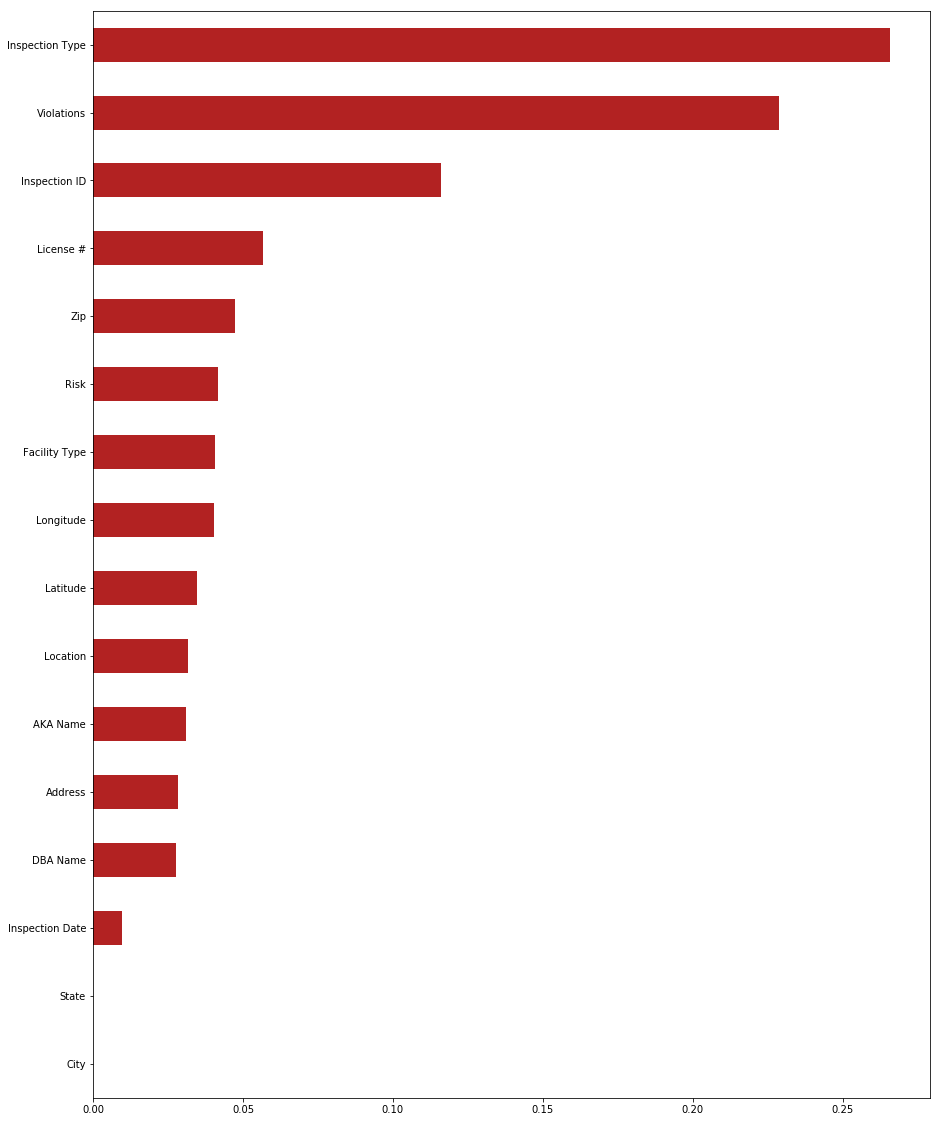

In [29]:
n = len(X_train.columns)
figsize = (15,20)

importances = pd.Series(best.feature_importances_, X_train.columns)

top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh(color='firebrick');

### Permutation Importance Results

In [39]:
# Fix for NaN error
from sklearn.metrics.scorer import check_scoring  # type: ignore
from sklearn.utils import check_array, check_random_state  # type: ignore

def fit(self, X, y, groups=None, **fit_params):
    # type: (...) -> PermutationImportance
    """Compute ``feature_importances_`` attribute and optionally
    fit the base estimator.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The training input samples.

    y : array-like, shape (n_samples,)
        The target values (integers that correspond to classes in
        classification, real numbers in regression).

    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set.

    **fit_params : Other estimator specific parameters

    Returns
    -------
    self : object
        Returns self.
    """
    self.scorer_ = check_scoring(self.estimator, scoring=self.scoring)

    if self.cv != "prefit" and self.refit:
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)

    X = check_array(X, force_all_finite=False) 
    #X = check_array(X)

    if self.cv not in (None, "prefit"):
        si = self._cv_scores_importances(X, y, groups=groups, **fit_params)
    else:
        si = self._non_cv_scores_importances(X, y)
    scores, results = si
    self.scores_ = np.array(scores)
    self.results_ = results
    self.feature_importances_ = np.mean(results, axis=0)
    self.feature_importances_std_ = np.std(results, axis=0)
    return self

PermutationImportance.fit = fit
perm = PermutationImportance(best)
perm.fit(X_test, y_test)
eli5.show_weights(perm)
# no errors, reports perm results just fine

Weight,Feature
0.0264 ± 0.0021,x0
0.0168 ± 0.0018,x11
0.0124 ± 0.0016,x12
0.0091 ± 0.0005,x3
0.0003 ± 0.0003,x9
0.0001 ± 0.0001,x1
0.0001 ± 0.0003,x14
0.0000 ± 0.0002,x4
0.0000 ± 0.0001,x6
0.0000 ± 0.0001,x2


In [40]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='roc_auc', cv='prefit',
                     n_iter=2, random_state=42)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=58,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=2, random_state=42, refit=True, scoring='roc_auc')

In [41]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0687 ± 0.0111,Violations
0.0570 ± 0.0041,Inspection Type
0.0338 ± 0.0016,Inspection ID
0.0096 ± 0.0002,Zip
0.0088 ± 0.0019,License #
0.0054 ± 0.0022,Longitude
0.0027 ± 0.0000,Latitude
0.0005 ± 0.0000,Address
0.0002 ± 0.0001,Location
0.0001 ± 0.0010,AKA Name


### Partial Dependance Results

In [42]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (51916, 16)


In [43]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)

Shape after removing features: (51916, 12)


In [47]:
# Refit the model after we remove features with zero importance

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=100, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 198 out of 200 | elapsed:  

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7da27bdf28>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7da27bd908>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [48]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.7036383688315544


In [49]:
best = search.best_estimator_
X_test = X_test[features]
y_pred_proba = best.predict_proba(X_test)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.6668494119296449


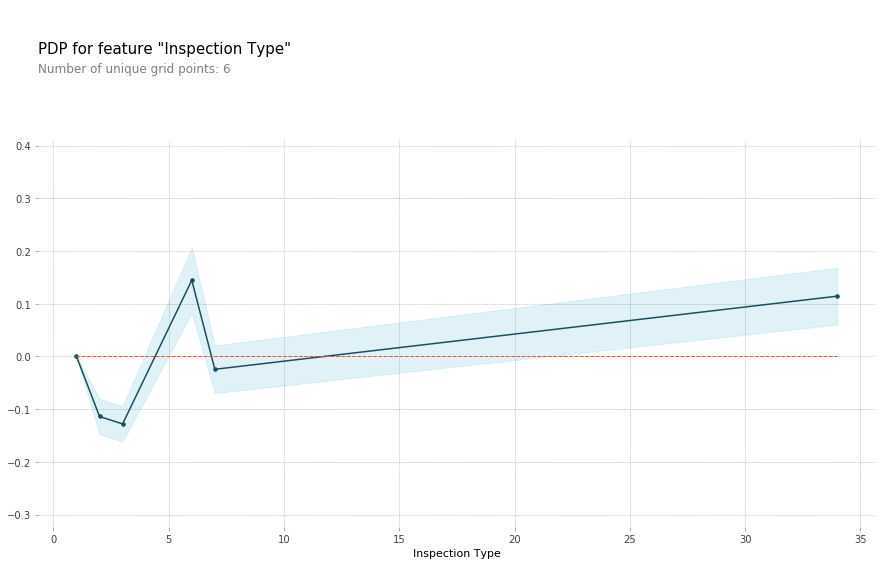

In [55]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature= 'Inspection Type'
isolated = pdp_isolate(model=best, dataset=X_test, model_features=X_test.columns, feature=feature)

pdp_plot(isolated, feature_name=feature);

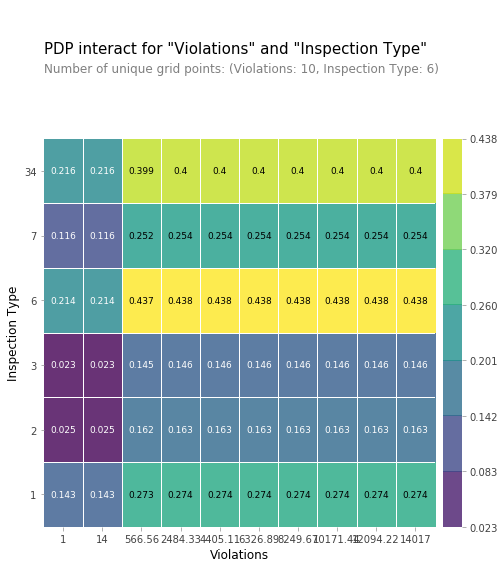

In [52]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Violations', 'Inspection Type']

interaction = pdp_interact(
    model=best, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Shapley Value Results

In [56]:
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)
confidence = np.abs(y_pred_proba - threshold)
preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 
                      'y_pred_proba': y_pred_proba, 
                      'confidence': confidence})

preds.head(50)

,y_test,y_pred,y_pred_proba,confidence
0,0,0,0.188977,0.311023
1,0,0,0.115984,0.384016
2,0,0,0.236653,0.263347
3,1,0,0.019412,0.480588
4,1,0,0.136597,0.363403
5,0,0,0.215971,0.284029
6,1,0,0.014999,0.485001
7,0,0,0.016780,0.483220
8,0,0,0.101284,0.398716
9,1,0,0.133996,0.366004


In [57]:
tp = preds[(y_pred==1) & (y_test==1)]
tp.sample(n=1)

,y_test,y_pred,y_pred_proba,confidence
10823,1,1,0.645098,0.145098


#### Shapley True Positive

In [58]:
data_for_prediction = X_test[X_test.index==10823]
data_for_prediction

,Inspection ID,DBA Name,AKA Name,License #,Address,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
10823,154463,6284,6079,2032670.0,6033,60657.0,1743,15,8771,41.943573,-87.649227,5940


In [59]:
shap.initjs()

explainer = shap.TreeExplainer(best)

shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

#### Shapley True Negative

In [60]:
tn = preds[(y_pred==0) & (y_test==0)]
tn.sample(n=1)

,y_test,y_pred,y_pred_proba,confidence
17005,0,0,0.063575,0.436425


In [61]:
data_for_prediction = X_test[X_test.index==17005]
data_for_prediction

,Inspection ID,DBA Name,AKA Name,License #,Address,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
17005,1591671,9909,9538,2229420.0,9119,60657.0,78,10,14,41.945133,-87.654677,8922


In [62]:
shap.initjs()

explainer = shap.TreeExplainer(best)

shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

#### Shapley False Positive

In [64]:
fp = preds[(y_pred==1) & (y_test==0)]
fp.sample(n=1)

,y_test,y_pred,y_pred_proba,confidence
12457,0,1,0.500407,0.000407


In [65]:
data_for_prediction = X_test[X_test.index==12457]
data_for_prediction

,Inspection ID,DBA Name,AKA Name,License #,Address,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
12457,679833,8157,103,2115052.0,7697,60623.0,1045,6,10076,41.836673,-87.732996,7554


In [66]:
shap.initjs()

explainer = shap.TreeExplainer(best)

shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

#### Shapley False Negative

In [67]:
fn = preds[(y_pred==0) & (y_test==1)]
fn.sample(n=1)

,y_test,y_pred,y_pred_proba,confidence
3720,1,0,0.14107,0.35893


In [68]:
data_for_prediction = X_test[X_test.index==3720]
data_for_prediction

,Inspection ID,DBA Name,AKA Name,License #,Address,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
3720,1583735,3112,3021,2320986.0,3072,60612.0,45,3,2997,41.881075,-87.684924,3036


In [69]:
shap.initjs()

explainer = shap.TreeExplainer(best)

shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

### Question 1:

#### What does Gradient Descent seek to minimize?

### Answer:

#### *Gradient Descent is seeking to minimize a function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient.*

### Question 2:

#### What is the "Learning Rate" and what is its function?

### Answer:

#### *The size of steps in either a negative or positive(left or right) direction down the gradient slope is called the learning rate*